In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import shutil
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save

In [14]:
## propofolPuffTone
# session = 'Mary-Anesthesia-20160809-01'
session = 'MrJones-Anesthesia-20160105-01'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## ketamine
# session = 'Mary-Anesthesia-20170315-01'
# session = 'MrJones-Anesthesia-20160805-01'
# session = 'MrJones-Anesthesia-20160808-01'
# session = 'Mary-Anesthesia-20170315-01'

## Load Neural Data

In [15]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [16]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 14.08 seconds)


# Load Results

In [21]:
VAR_all_results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"
window = 5
stride = 5
VAR_results_dir = get_result_path(VAR_all_results_dir, session, window, stride)

In [22]:
VAR_results = {}
for file in tqdm(os.listdir(VAR_results_dir)):
    try:
        VAR_results[file] = load(os.path.join(VAR_results_dir, file))
    except IsADirectoryError:
        print(f"Need to compile {os.path.join(VAR_results_dir, file)}")
        # compile results
        VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))

  0%|          | 0/5 [00:00<?, ?it/s]

# Plot

## Individual Areas

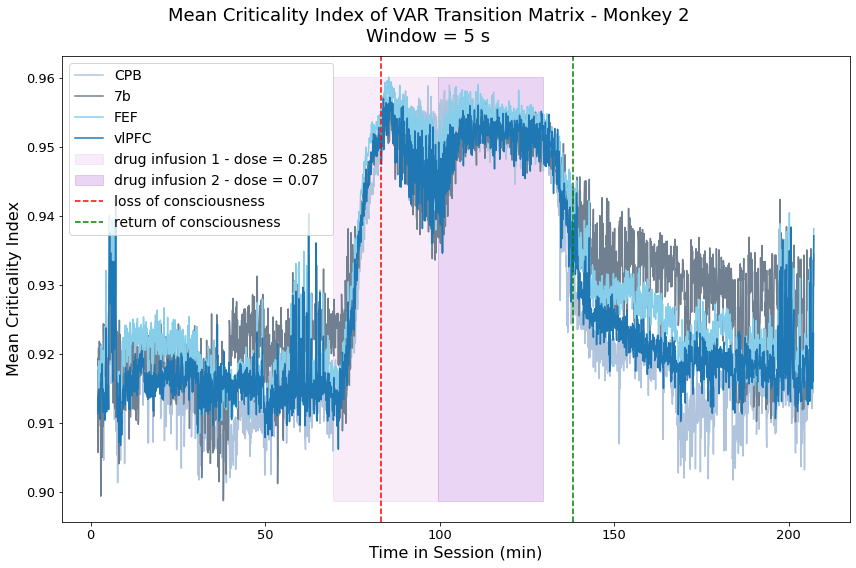

In [23]:
plot_individual_areas(session, data_class, VAR_results, window, stride, session_info, start_time=125, end_time=None)

## Multipopulation

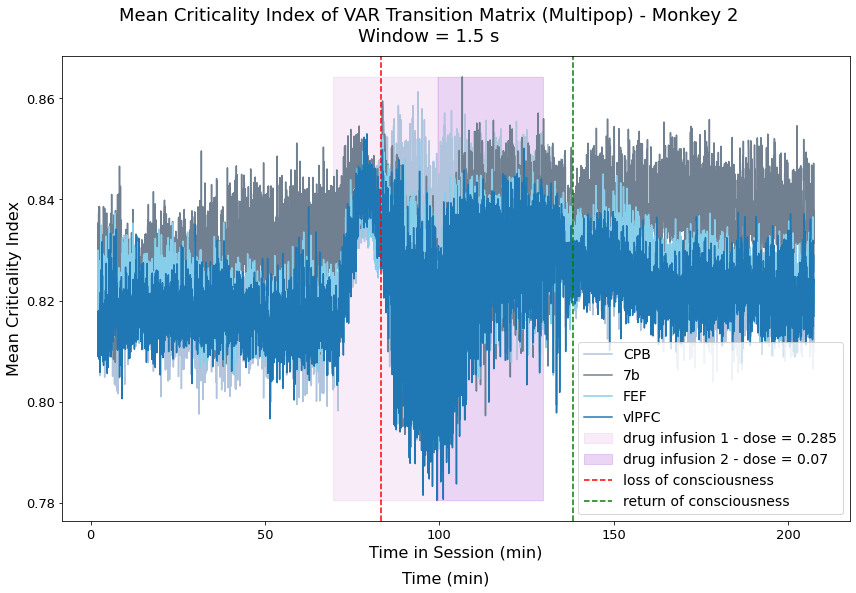

In [20]:
plot_multipopulation(session, data_class, VAR_results, window, stride, session_info, electrode_info, start_time=125, end_time=None)

## Criticality Distribution Single Area

In [12]:
area = 'all'

In [13]:
bin_nums = 20
bin_min = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).min()
bin_min = 0.85
# bin_max = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).max()
bin_max = 1.03
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results[area].criticality_inds.shape[0], bin_nums))
for t in range(VAR_results[area].criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results[area].criticality_inds[t], bins=bins)[0]

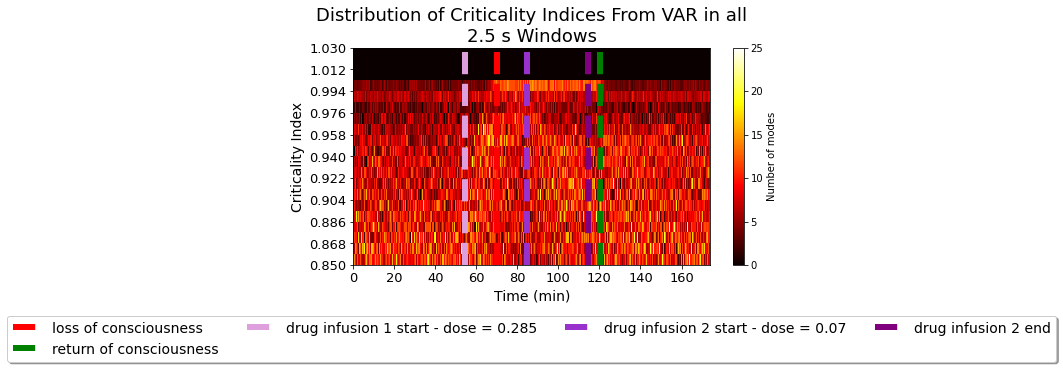

In [14]:
lw = 6
plt.figure(figsize=(8, 4))
plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
xticks = plt.xticks()
T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
plt.xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
plt.yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.xlabel("Time (min)", fontsize=14)
plt.ylabel("Criticality Index", fontsize=14)
plt.title(f"Distribution of Criticality Indices From VAR in {area}\n{window} s Windows", fontsize=18)
plt.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/stride, linestyle='--', lw=lw, c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
plt.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
plt.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
plt.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
#     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
plt.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=True)
plt.colorbar(label="Number of modes")
# plt.ylim()
# plt.tight_layout()
plt.show()

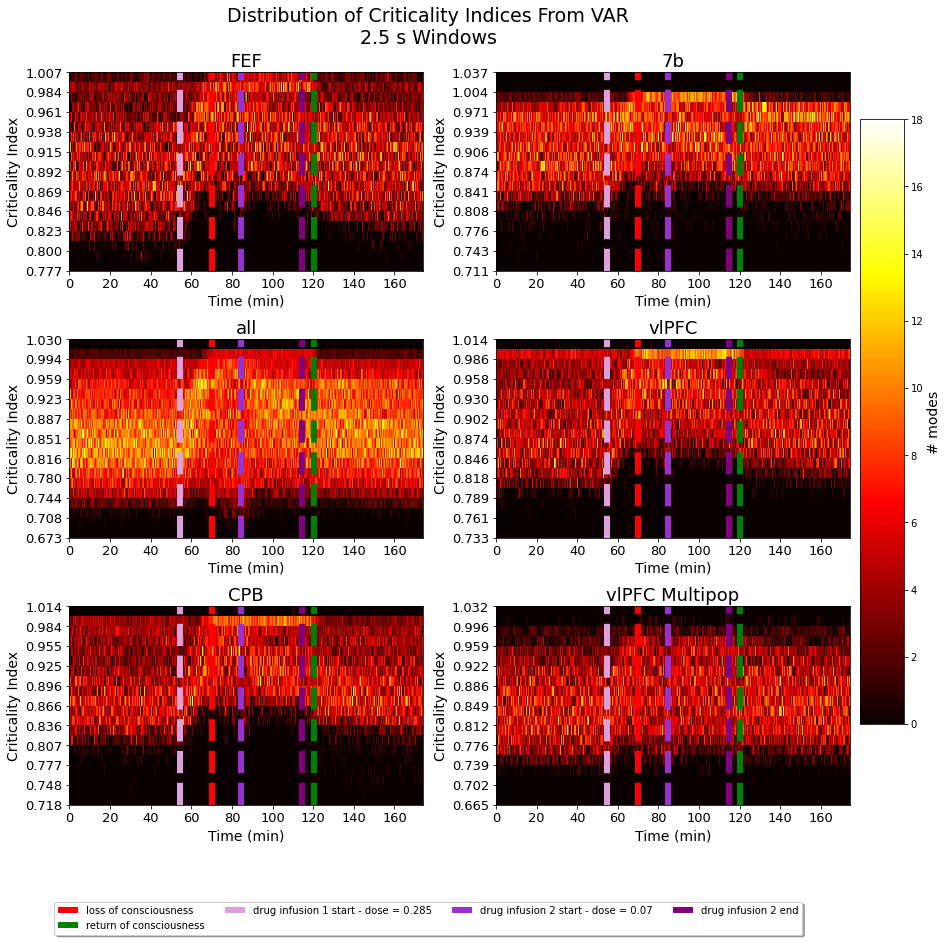

In [23]:
lw = 6
rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
for i, area in enumerate(VAR_results.keys()):
    ax = axs[int(i/cols)][i % cols]
    
    bin_nums = 20
    bin_min = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).min()
#     bin_min = 0.88
#     if area == 'all':
#         bin_min = 0.85
#     elif area == 'Thal':
#         bin_min = 0.98
    bin_max = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).max()
#     bin_max = 1.03
    if area == 'Thal':
        bin_max = 1.01
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results[area].criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results[area].criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results[area].criticality_inds[t], bins=bins)[0]

    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot')
    start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
    T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
    ax.set_xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
    ax.set_yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Time (min)", fontsize=14)
    ax.set_ylabel("Criticality Index", fontsize=14)
    ax.set_title(f"{area}", fontsize=18)
    ax.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/stride, linestyle='--', lw=lw, c='red', label="loss of consciousness")
    ax.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
    ax.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
    ax.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
    ax.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
    handles, labels = ax.get_legend_handles_labels()
    # ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
    #     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
#     ax.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
#     plt.colorbar(label="Number of modes")

plt.suptitle(f"Distribution of Criticality Indices From VAR\n{window} s Windows", fontsize=19)
fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(label='# modes', fontsize=14)
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
plt.show()

# Test

In [55]:
i = 0
area = 'all'

In [86]:
unit_indices = run_params['unit_indices'][area]
T_pred = 25
row = results[area].iloc[i]
x0 = lfp[row.start_step + int(run_params['window']/dt) - 1, unit_indices]
predictions = np.zeros((T_pred, len(unit_indices)))
for t in range(T_pred):
    if t == 0:
        predictions[t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
    else:
        predictions[t] = np.concatenate([[1], predictions[t-1]]) @ row.A_mat_with_bias

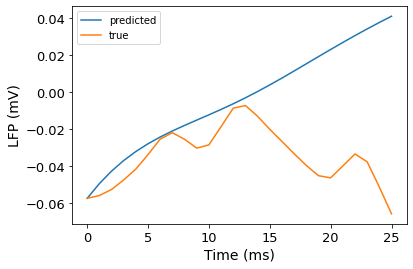

In [111]:
unit_num = 2
plt.plot(np.concatenate([[x0], predictions])[:, unit_num], label='predicted')
plt.plot(lfp[row.start_step + int(run_params['window']/dt) - 1:row.start_step + int(run_params['window']/dt) + T_pred, unit_indices[unit_num]], label='true')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('LFP (mV)', fontsize=14)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.legend()
plt.show()